# Example: run MultiSolSegment and validate
This examples hows how to download the weights for MultiSolSegment, run it on an image to segment crack, dark and busbar masks. Then use pvimage to look at crack count and parameters

In [86]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader

from pvcracks.utils import viz_functions, train_functions

import requests

from pvimage import features

## Step 1: Download Model

DOI - https://doi.org/10.21948/2997859  
Direct Link - https://datahub.duramat.org/dataset/24d7ed98-956e-4ebc-bf21-6584ecec2ff1/resource/e6d5dee2-0aef-439e-978c-d8c572e7039e/download/model.pt

In [104]:
weight_path = "multisolsegment.pt"
response = requests.get("https://datahub.duramat.org/dataset/24d7ed98-956e-4ebc-bf21-6584ecec2ff1/resource/e6d5dee2-0aef-439e-978c-d8c572e7039e/download/model.pt")

with open(weight_path, "wb") as f:
    f.write(response.content)

## Step 2: Download and Load Images

DOI - https://doi.org/10.21948/2587738  
Direct Link - https://datahub.duramat.org/dataset/5e7587ad-6ad1-4d6f-8432-70940a6d7ca1/resource/8f12be45-b929-4f5c-9400-84dde27b0e90/download/labeledelcells.zip

## Step 3: Set local paths

In [88]:
files_root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Channeled_Combined_CWRU_LBNL_ASU_No_Empty/"

# if you have have already downloaded model weights, replace this with the local path
# weight_path = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Channeled_Combined_CWRU_LBNL_ASU_No_Empty/checkpoints/Channeled_Combined_CWRU_LBNL_ASU_No_Empty10/epoch_19/model.pt"

## Step 4: Load in everything

In [89]:
category_mapping = {0: "dark", 1: "busbar", 2: "crack", 3: "non-cell"}

root = Path(files_root)
img_root = root / "img" / "all"

train_dataset, val_dataset = train_functions.load_dataset(root)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
device, model = train_functions.load_device_and_model(
    category_mapping, existing_weight_path=weight_path
)

## Step 5: Pick image and threshold

Index is what image to run this model on.  

Threshold is what confidence % we want to code as an actual detection target, rather than just background noise.

In [90]:
idx = 7
threshold = 0.5 # default

## Step 6: Inference and Show

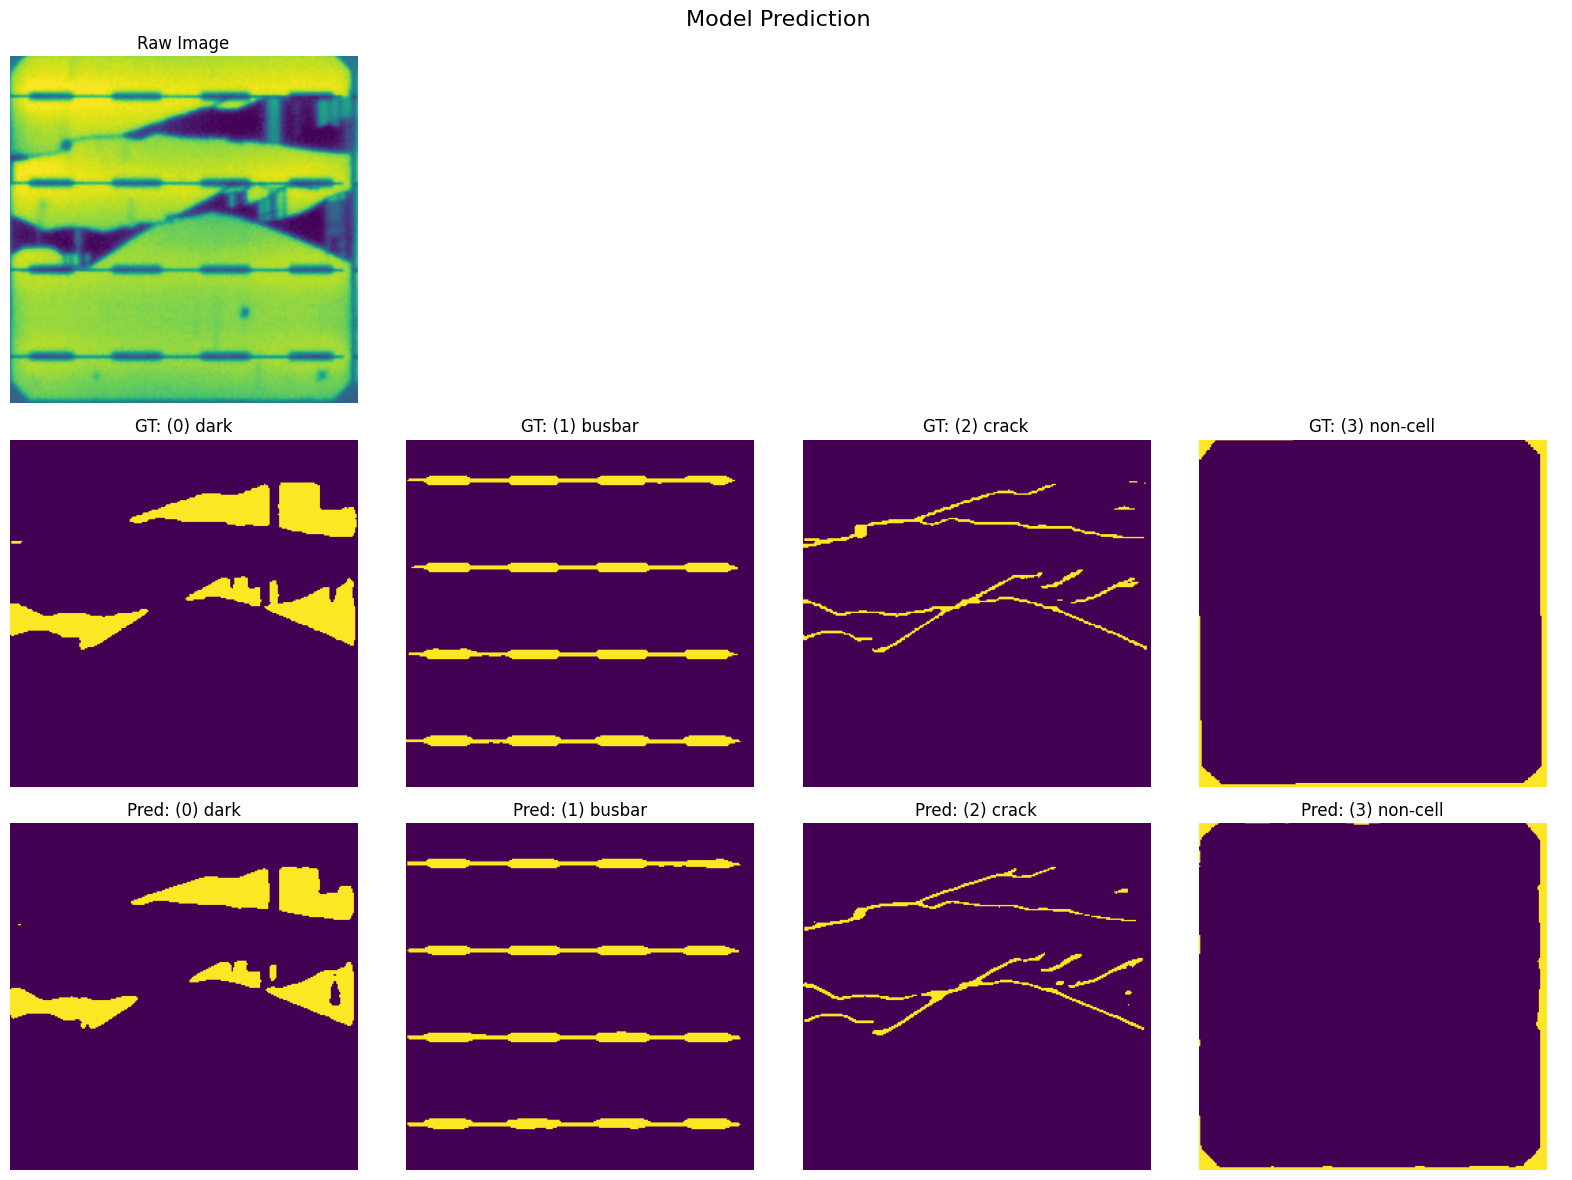

In [91]:
viz_functions.channeled_inference_and_show(
    val_loader, device, model, category_mapping, idx, threshold
)

## Step 7: Investigate dark area %

In [92]:
def channel_activation_percentages(mask, category_mapping):
    """
    Calculate the percentage of pixels activated for each channel in a multi-hot mask.

    Args:
        mask: 3D array-like of shape (n_channels, height, width) containing multi-hot activations.
        category_mapping (dict): Mapping from channel index to class name. The iteration order
            defines the channel order in the mask tensor.

    Returns:
        dict: Mapping from class name to percentage (0-100) of activated pixels in that channel.
    """

    mask_np = np.asarray(mask)

    if mask_np.ndim != 3:
        raise ValueError(
            f"Expected a 3D mask of shape (channels, height, width); got {mask_np.shape}."
        )

    n_channels, height, width = mask_np.shape
    total_pixels = height * width

    if total_pixels == 0:
        raise ValueError("Mask must contain at least one pixel.")

    percentages = {}
    for channel_idx, class_name in category_mapping.items():
        if channel_idx >= n_channels:
            raise ValueError(
                f"Channel index {channel_idx} for class '{class_name}' is out of bounds "
                f"for mask with {n_channels} channel(s)."
            )
        channel_activation = mask_np[channel_idx].sum()
        percentages[class_name] = (
            float(channel_activation) / float(total_pixels) * 100.0
        )

    return percentages

def print_channel_activation_percentages(percentages):
    print("Predicted channel activation (% of image):")
    sum = 0
    for _, class_name in category_mapping.items():
        print(f"\t{class_name}: {percentages[class_name]:.2f}%")
        sum += percentages[class_name]
    print("\tRemaining (solar cell): %.2f%%\n" % (100 - sum))

In [93]:
img, mask = val_loader.dataset.__getitem__(idx)
img = img.to(device)
img_path = val_loader.dataset.__get_img_path__(idx)

logits = model(img.unsqueeze(0)).detach().cpu()
probs = torch.sigmoid(logits)  
pred_mask = (probs > threshold).float().squeeze(0).numpy()

gt_mask = mask.cpu().numpy()

gt_percentages = channel_activation_percentages(gt_mask, category_mapping)
pred_percentages = channel_activation_percentages(pred_mask, category_mapping)

print_channel_activation_percentages(gt_percentages)
print_channel_activation_percentages(pred_percentages)

Predicted channel activation (% of image):
	dark: 11.16%
	busbar: 7.75%
	crack: 3.05%
	non-cell: 3.70%
	Remaining (solar cell): 74.34%

Predicted channel activation (% of image):
	dark: 10.31%
	busbar: 7.81%
	crack: 3.08%
	non-cell: 3.70%
	Remaining (solar cell): 75.10%



## Step 8: Crack mask features with PVImage

Extract predicted crack masks, compute crack statistics with PVImage, and visualize the distribution of key metrics.


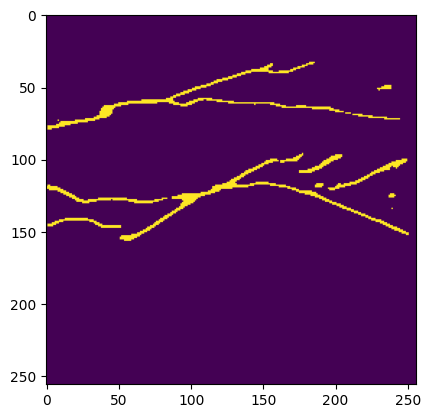

In [94]:
img, mask = val_loader.dataset.__getitem__(idx)
img = img.to(device)
img_path = val_loader.dataset.__get_img_path__(idx)

logits = model(img.unsqueeze(0)).detach().cpu()
probs = torch.sigmoid(logits)  
pred_mask = (probs > threshold).float().squeeze(0).numpy()

fig, ax = plt.subplots()
ax.imshow(pred_mask[2], cmap="viridis")

In [95]:
crack_mask = (pred_mask[2] * 255).astype(np.uint8)  # Convert [0,1] to [0,255]

# Create DataFrame with image path
dfinfo = pd.DataFrame()
dfinfo["impath"] = [str(img_path)]  # Wrap in list

# Run feature extraction
dffeaturesreal = features.feature_extraction_crack_mask([crack_mask], dfinfo)
dffeaturesreal.head()

,cell_number,i,prop.perimeter,slope,prop.convex_area,prop.area,prop.orientation
0,mxy_0540,4,745.404112,-2.728464,13499.0,5157.0,-1.459944
0,mxy_0540,0,332.468037,-1.693958,3134.0,1898.0,-1.429506
0,mxy_0540,2,149.59798,-1.927778,949.0,789.0,-1.273929


In [96]:
def violinplt(data, palette=None, figsize=(5, 4)):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Coerce to DataFrame so .mean() and column names behave
    if isinstance(data, pd.Series):
        data = data.to_frame()
    elif not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data)

    fig, ax = plt.subplots(figsize=figsize)

    # Seaborn API: no widths/showmeans/showmedians/showextrema here
    # Use inner="quartile" to show quartiles; cut=0 to avoid extrapolation
    sns.violinplot(
        data=data,
        ax=ax,
        palette=palette,
        inner="quartile",
        cut=0,
        linewidth=1,
    )

    # Overlay means as points
    means = data.mean().to_numpy()
    x_pos = np.arange(len(means))
    ax.scatter(x_pos, means, zorder=3)

    # Prepare mean labels
    nobs = [f"{m:.2f}" for m in means]

    # Place mean labels slightly above the point
    y_offset = 0.03 * (
        np.nanmax(means) - np.nanmin(means) if np.all(np.isfinite(means)) else 1.0
    )
    if len(x_pos) > 3:
        for i in x_pos:
            t = ax.text(
                i,
                means[i] + y_offset,
                nobs[i],
                ha="center",
                va="bottom",
                fontsize=10,
                color="black",
                weight="semibold",
            )
            # subtle white box for readability
            t.set_bbox(
                dict(
                    facecolor="white",
                    alpha=0.5,
                    edgecolor="none",
                    boxstyle="round,pad=0.15",
                )
            )
        # Rotate tick labels cleanly
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    else:
        for i in x_pos:
            ax.text(
                i,
                means[i] + y_offset,
                nobs[i],
                ha="center",
                va="bottom",
                fontsize=12,
                color="black",
                weight="semibold",
            )

    ax.set_ylabel("Value")
    ax.set_xlabel("")
    ax.margins(x=0.05)
    fig.tight_layout()
    return fig

In [97]:
dffeaturesreal["count_features"] = dffeaturesreal.groupby("cell_number")[
    "cell_number"
].transform("count")
dffeaturesrealcount = dffeaturesreal.sort_values(by="cell_number").drop_duplicates(
    "cell_number", keep="first"
)

In [98]:
dffeaturesrealcount.reset_index(drop=True, inplace=True)

featurescounted = pd.concat(
    [dffeaturesrealcount["count_features"]], axis=1, ignore_index=True
)
featurescounted.columns = ["Original"]
featurescounted.head()

,Original
0,3


/var/folders/_l/7n7n98ws5fx8zfcbxfmfs7fh0000gn/T/ipykernel_3419/2437796597.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dffeaturesall_norm[columnstonormalize] = scaler.fit_transform(dffeaturesall_norm)


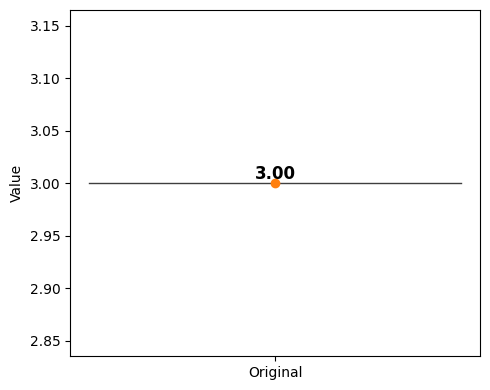

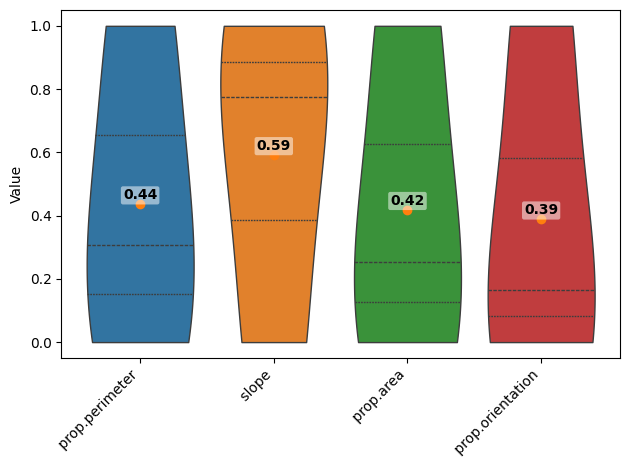

In [99]:
from sklearn.preprocessing import MinMaxScaler


dffeaturesall = dffeaturesreal


vp = violinplt(featurescounted[["Original"]], figsize=(5, 4))


scaler = MinMaxScaler()
columnstonormalize = [
    " prop.perimeter",
    " slope",
    " prop.area",
    " prop.orientation",
]
dffeaturesall_norm = dffeaturesall[columnstonormalize]
dffeaturesall_norm[columnstonormalize] = scaler.fit_transform(dffeaturesall_norm)
fig = violinplt(
    dffeaturesall_norm[
        [
            " prop.perimeter",
            " slope",
            " prop.area",
            " prop.orientation",
        ]
    ],
    figsize=None,
)
# fig.savefig("violins.png", bbox_inches="tight")

## Step 9: PVImage stats for many images

In [100]:
m_idx = len(val_loader.dataset)  # indices to process
masks = []
impaths = []

for i in range(m_idx):
    img, _ = val_loader.dataset.__getitem__(i)
    img = img.to(device)
    img_path = val_loader.dataset.__get_img_path__(i)

    # model inference
    logits = model(img.unsqueeze(0)).detach().cpu()
    probs = torch.sigmoid(logits)
    pred_mask = (probs > threshold).float().squeeze(0).numpy()  # (n_classes, H, W)

    # Extract crack channel (index 2) and convert to uint8 [0,255]
    crack_mask = (pred_mask[2] * 255).astype(np.uint8)

    masks.append(crack_mask)
    impaths.append(str(img_path))

# Build dataframe of image paths expected by feature_extraction_crack_mask
dfinfo_multi = pd.DataFrame({"impath": impaths})

# Run PVImage feature extraction across all predicted crack masks
dffeatures_multi = features.feature_extraction_crack_mask(masks, dfinfo_multi)
display(dffeatures_multi.head())

/Users/ojas/Desktop/saj/SANDIA/pvcracks/.venv/lib/python3.11/site-packages/pvimage/features.py:59: RuntimeWarning: invalid value encountered in divide
  mask2n = mask2/mask2.max()
/Users/ojas/Desktop/saj/SANDIA/pvcracks/.venv/lib/python3.11/site-packages/pvimage/features.py:59: RuntimeWarning: invalid value encountered in divide
  mask2n = mask2/mask2.max()
/Users/ojas/Desktop/saj/SANDIA/pvcracks/.venv/lib/python3.11/site-packages/pvimage/features.py:59: RuntimeWarning: invalid value encountered in divide
  mask2n = mask2/mask2.max()
/Users/ojas/Desktop/saj/SANDIA/pvcracks/.venv/lib/python3.11/site-packages/pvimage/features.py:59: RuntimeWarning: invalid value encountered in divide
  mask2n = mask2/mask2.max()
/Users/ojas/Desktop/saj/SANDIA/pvcracks/.venv/lib/python3.11/site-packages/pvimage/features.py:59: RuntimeWarning: invalid value encountered in divide
  mask2n = mask2/mask2.max()
/Users/ojas/Desktop/saj/SANDIA/pvcracks/.venv/lib/python3.11/site-packages/pvimage/features.py:59: R

,cell_number,i,prop.perimeter,slope,prop.convex_area,prop.area,prop.orientation
0,mxy_sa19965_sub_EL_9,2,271.740115,-0.298467,2296.0,1497.0,-0.486834
0,mxy_sa19965_sub_EL_9,8,266.468037,-0.155785,1826.0,1403.0,-0.386939
0,mxy_sa19965_sub_EL_9,4,235.39697,-1.476617,2109.0,1289.0,-1.394845
0,mxy_sa19965_sub_EL_9,5,233.39697,0.500036,2353.0,1422.0,0.739917
0,SW2,2,144.727922,1.327726,806.0,731.0,1.509887


In [101]:
dffeatures_multi["count_features"] = dffeatures_multi.groupby("cell_number")[
    "cell_number"
].transform("count")
dffeatures_multi_count = (
    dffeatures_multi.sort_values(by="cell_number")
    .drop_duplicates(
        "cell_number", keep="first"
    )
)
dffeatures_multi_count.reset_index(drop=True, inplace=True)

featurescounted_multi = pd.concat(
    [dffeatures_multi_count["count_features"]], axis=1, ignore_index=True
)
featurescounted_multi.columns = ["Original"]

# Show basic outputs
print(f"Processed {len(masks)} images, extracted {len(dffeatures_multi)} feature rows.")
display(featurescounted_multi.head())

Processed 585 images, extracted 605 feature rows.


,Original
0,1
1,2
2,1
3,3
4,3


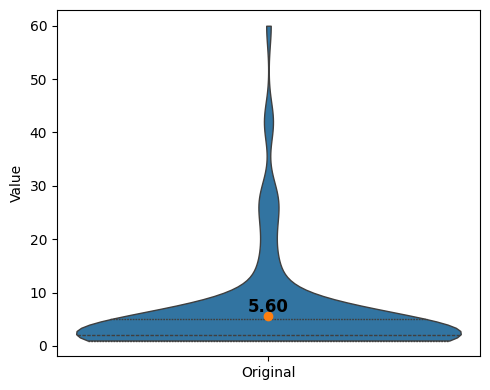

In [102]:
vp = violinplt(featurescounted_multi[["Original"]], figsize=(5, 4))

/var/folders/_l/7n7n98ws5fx8zfcbxfmfs7fh0000gn/T/ipykernel_3419/3940485898.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dffeatures_multi_norm[columnstonormalize] = scaler.fit_transform(dffeatures_multi_norm)


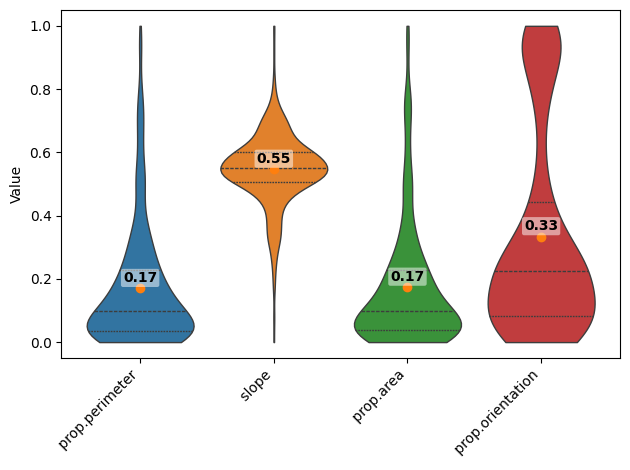

In [103]:
scaler = MinMaxScaler()
columnstonormalize = [
    " prop.perimeter",
    " slope",
    " prop.area",
    " prop.orientation",
]
dffeatures_multi_norm = dffeatures_multi[columnstonormalize]
dffeatures_multi_norm[columnstonormalize] = scaler.fit_transform(dffeatures_multi_norm)
fig = violinplt(
    dffeatures_multi_norm[
        [
            " prop.perimeter",
            " slope",
            " prop.area",
            " prop.orientation",
        ]
    ],
    figsize=None,
)